%%capture
!pip install scanpy
!pip install KDEpy
!pip install leidenalg

In [1]:
import os
import sys

import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.stats import spearmanr

# to be able to import from tools dir
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# os.environ['R_HOME'] = "/Library/Frameworks/R.framework/Resources"
# import pertpy as pt
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.scDEED as scd
import tools.clustering_opt as co
import tools.util_plot as nmd_plot

import fi_nomad as nmd
from fi_nomad.types import kernelInputTypes
from fi_nomad.types import KernelStrategy
from fi_nomad.types import InitializationStrategy

from itertools import product
from tools.nuclear_norm_init import nuclear_norm_init

import warnings
warnings.filterwarnings("ignore")

from scipy.stats import pearsonr
import importlib
import logging

In [2]:
# logging has to manually turned on to see nomad output
logging.basicConfig(level=logging.INFO)

In [3]:
data_all_pca = sc.read_h5ad("../../data/export_s3.h5ad")
data_all_pca

AnnData object with n_obs × n_vars = 1544 × 5553
    obs: 'total_counts', 'n_genes_by_counts', 'leiden_opt'
    var: 'total_counts', 'n_cells_by_counts', 'TU_ID', 'nb_overdisp_cutoff', 'pval_cluster_0', 'pval_cluster_1', 'pval_cluster_2', 'pval_cluster_3'
    uns: 'leiden', 'leiden_opt_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [4]:
data_all_pca.varm["PCs"].shape

(5553, 50)

In [5]:
data_counts = sc.read_h5ad("../../data/S3_filtered_with_counts.h5ad")
data_counts

AnnData object with n_obs × n_vars = 1544 × 5553
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'nb_mean', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_overdisp_cutoff_bfgs', 'nb_overdisp_bfgs', 'mean', 'std'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts', 'vst_counts'

In [6]:
importlib.reload(nmd_plot)

<module 'tools.util_plot' from '/Users/stffn/projects/thesis_dev/msc_thesis/application/tools/util_plot.py'>

In [7]:
data_counts.X = data_counts.layers["counts"].copy()

In [8]:
# Normalizes X, such that: each cell has total count equal to median of total counts before normalization
sc.pp.normalize_total(data_counts, target_sum=None, layer=None)

# Only normalization
data_counts.layers["normalized_counts"] = data_counts.X.copy()


### Search latent dimensions

In [9]:
data_train, data_test = cs.countsplit_adata(data_counts, data_dist="NB", beta_key="nb_overdisp_cutoff", 
                                            layer="counts", min_genes=1, max_counts=1e9, seed=198745198)

In [23]:
row_target_sum = np.median(data_counts.obs["total_counts"])
row_target_sum

794.5

In [22]:
np.sum(data_counts.layers["normalized_counts"][0,:])


794.5000000000055

In [24]:
# Normalizes X, such that: each barcode has total count equal to median of total counts before normalization
sc.pp.normalize_total(data_train, target_sum=row_target_sum, layer=None)

# Only normalization
data_train.layers["normalized_counts"] = data_train.X.copy()

# test data
sc.pp.normalize_total(data_test, target_sum=row_target_sum, layer=None)
data_test.layers["normalized_counts"] = data_test.X.copy()

In [25]:
print(np.sum(data_train.layers["normalized_counts"][0,:]))
print(np.sum(data_test.layers["normalized_counts"][0,:]))

794.4992
794.50073


In [26]:
importlib.reload(cs)

<module 'tools.countsplit' from '/Users/stffn/projects/thesis_dev/msc_thesis/application/tools/countsplit.py'>

In [32]:
ks_2_check = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
betas_2_check = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

corrected NMD-3B countsplit parameter search function:

In [33]:
def generate_dataframe(val_colname="loss", **kwargs):
    """
    Generate a pandas DataFrame with all combinations of values from the input dictionaries.

    Parameters:
        val_colname (str): Name for the empty column. Default is 'loss'.
        **kwargs: Variable number of dictionaries containing column names as keys and values to generate combinations from.

    Returns:
        pd.DataFrame: DataFrame containing all combinations of values from the input dictionaries.
                      The DataFrame has columns specified by the keys of the dictionaries,
                      and an additional empty column with the specified name.
    """
    # Extract column names and values from kwargs
    columns = list(kwargs.keys())
    values = list(kwargs.values())

    # Generate all combinations of values
    combinations = list(product(*values))

    # Create DataFrame with columns based on column names
    df = pd.DataFrame(combinations, columns=columns)
    df[val_colname] = pd.Series(dtype=float)  # Creating an empty column

    return df


def add_result(df, val_col, val, **kwargs):
    """
    Assign a value to the specified column based on the values of the input lists.

    Parameters:
        df (pd.DataFrame): DataFrame to update.
        val_col (str): Name of the column to assign the value.
        val: Value to assign.
        **kwargs: Keyword arguments representing the values of the input lists.

    Returns:
        pd.DataFrame: Updated DataFrame with the specified value assigned to the column.
    """
    # Filter DataFrame based on provided values
    mask = pd.Series(True, index=df.index)
    for key, value in kwargs.items():
        mask &= df[key] == value

    # Assign value to specified column
    df.loc[mask, val_col] = val

    return df

def convert_to_dense(adata, layer=None):
    """Gets specified layer from an adata object, converts it to dense array"""
    if layer is None:
        count_data = adata.X
    else:
        count_data = adata.layers[layer]

    if type(count_data) == sps._csr.csr_matrix:
        count_data = count_data.toarray()
    # count_data = count_data.astype(int)

    return count_data


In [34]:
def select_3b_params_nomad_countsplit(
    train_data,
    test_data,
    potential_ks=[10, 9, 8, 7, 6, 5, 4, 3, 2, 1],
    layer="counts",
    potential_betas=[0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
):

    X_train = convert_to_dense(train_data, layer=layer)
    X_test = convert_to_dense(test_data, layer=layer)

    m, n = X_train.shape

    results_df = generate_dataframe(
        k=potential_ks, beta=potential_betas, val_colname="loss"
    )

    init_strat = InitializationStrategy.KNOWN_MATRIX
    kernel_strat = KernelStrategy.MOMENTUM_3_BLOCK_MODEL_FREE

    for k in potential_ks:
        print(f"################## LATENT DIM {k}")

        W0, H0 = nuclear_norm_init(X_train, m, n, k)

        for beta in potential_betas:
            print(f"################## BETA {beta}")
            kernel_parameters = kernelInputTypes.Momentum3BlockAdditionalParameters(
                momentum_beta=beta,
                candidate_factor_W0=W0,
                candidate_factor_H0=H0,
            )
            result = nmd.decompose(
                X_train,
                k,
                kernel_strategy=kernel_strat,
                initialization=init_strat,
                kernel_params=kernel_parameters,
                manual_max_iterations=100,
                verbose=True,
                tolerance=None,
            )

            W = result.factors[0]
            H = result.factors[1]

            results_df = add_result(
                results_df,
                val_col="loss",
                val=np.linalg.norm(X_test - np.maximum(0, W @ H), ord="fro"),
                k=k,
                beta=beta,
            )
    return results_df

In [35]:
select_cs_results = select_3b_params_nomad_countsplit(
    data_train, data_test, potential_ks=ks_2_check, 
    potential_betas=betas_2_check, layer="normalized_counts")

################## LATENT DIM 10


INFO:fi_nomad.entry:	Initiating run, target_rank: 10, tolerance: None


################## BETA 0.4


INFO:fi_nomad.entry:100 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.8509999538073316e-05 loop took 21.896672057000615 overall (0.21896672057000616/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 10, tolerance: None


################## BETA 0.5


INFO:fi_nomad.entry:100 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.2430999706557486e-05 loop took 22.28019883700017 overall (0.2228019883700017/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 10, tolerance: None


################## BETA 0.6


INFO:fi_nomad.entry:100 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.3691000023973174e-05 loop took 22.220886942000107 overall (0.22220886942000107/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 10, tolerance: None


################## BETA 0.7


INFO:fi_nomad.entry:100 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 5.550799960474251e-05 loop took 21.875278735000393 overall (0.21875278735000392/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 10, tolerance: None


################## BETA 0.8


INFO:fi_nomad.entry:100 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.318599945283495e-05 loop took 21.80546281199986 overall (0.2180546281199986/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 10, tolerance: None


################## BETA 0.9


INFO:fi_nomad.entry:100 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.3829000383557286e-05 loop took 22.555379911999808 overall (0.22555379911999807/ea)


################## LATENT DIM 9


INFO:fi_nomad.entry:	Initiating run, target_rank: 9, tolerance: None


################## BETA 0.4


INFO:fi_nomad.entry:100 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.6478999643586576e-05 loop took 21.49026886700085 overall (0.2149026886700085/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 9, tolerance: None


################## BETA 0.5


INFO:fi_nomad.entry:100 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.221100021415623e-05 loop took 21.671263375999843 overall (0.2167126337599984/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 9, tolerance: None


################## BETA 0.6


INFO:fi_nomad.entry:100 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.4418000066361856e-05 loop took 22.212516325999786 overall (0.22212516325999787/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 9, tolerance: None


################## BETA 0.7


INFO:fi_nomad.entry:100 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.1505999939108733e-05 loop took 22.425296868999794 overall (0.22425296868999794/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 9, tolerance: None


################## BETA 0.8


INFO:fi_nomad.entry:100 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.4497000595147256e-05 loop took 22.684652692999407 overall (0.22684652692999407/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 9, tolerance: None


################## BETA 0.9


INFO:fi_nomad.entry:100 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.0170000172802247e-05 loop took 23.868407353999828 overall (0.2386840735399983/ea)


################## LATENT DIM 8


INFO:fi_nomad.entry:	Initiating run, target_rank: 8, tolerance: None


################## BETA 0.4


INFO:fi_nomad.entry:100 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.5718999495438766e-05 loop took 22.857427158000064 overall (0.22857427158000065/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 8, tolerance: None


################## BETA 0.5


INFO:fi_nomad.entry:100 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.789000038523227e-05 loop took 22.706465301999742 overall (0.22706465301999743/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 8, tolerance: None


################## BETA 0.6


INFO:fi_nomad.entry:100 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.348900008859346e-05 loop took 22.674784474999797 overall (0.22674784474999796/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 8, tolerance: None


################## BETA 0.7


INFO:fi_nomad.entry:100 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.105999985564267e-05 loop took 22.531528718000118 overall (0.22531528718000118/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 8, tolerance: None


################## BETA 0.8


INFO:fi_nomad.entry:100 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.523099919926608e-05 loop took 22.47275684000033 overall (0.2247275684000033/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 8, tolerance: None


################## BETA 0.9


INFO:fi_nomad.entry:100 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 4.252500002621673e-05 loop took 23.595534071999282 overall (0.23595534071999283/ea)


################## LATENT DIM 7


INFO:fi_nomad.entry:	Initiating run, target_rank: 7, tolerance: None


################## BETA 0.4


INFO:fi_nomad.entry:100 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.8252999982214533e-05 loop took 22.24702528599937 overall (0.2224702528599937/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 7, tolerance: None


################## BETA 0.5


INFO:fi_nomad.entry:100 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.6927999897452537e-05 loop took 22.06029557599959 overall (0.2206029557599959/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 7, tolerance: None


################## BETA 0.6


INFO:fi_nomad.entry:100 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.3594000595039688e-05 loop took 22.064924931999485 overall (0.22064924931999486/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 7, tolerance: None


################## BETA 0.7


INFO:fi_nomad.entry:100 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.32669997078483e-05 loop took 22.183717269000226 overall (0.22183717269000225/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 7, tolerance: None


################## BETA 0.8


INFO:fi_nomad.entry:100 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.4498999664501753e-05 loop took 22.297054006000508 overall (0.22297054006000508/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 7, tolerance: None


################## BETA 0.9


INFO:fi_nomad.entry:100 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.5535000531817786e-05 loop took 23.44222622399957 overall (0.23442226223999568/ea)


################## LATENT DIM 6


INFO:fi_nomad.entry:	Initiating run, target_rank: 6, tolerance: None


################## BETA 0.4


INFO:fi_nomad.entry:100 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.5164000362565275e-05 loop took 28.852073256999574 overall (0.2885207325699957/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 6, tolerance: None


################## BETA 0.5


INFO:fi_nomad.entry:100 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.928300000348827e-05 loop took 23.674708606999957 overall (0.23674708606999956/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 6, tolerance: None


################## BETA 0.6


INFO:fi_nomad.entry:100 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.3734000023978297e-05 loop took 21.038553267999305 overall (0.21038553267999305/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 6, tolerance: None


################## BETA 0.7


INFO:fi_nomad.entry:100 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.3546999727841467e-05 loop took 24.421621198999674 overall (0.24421621198999674/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 6, tolerance: None


################## BETA 0.8


INFO:fi_nomad.entry:100 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.507799945306033e-05 loop took 23.134650345999944 overall (0.23134650345999944/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 6, tolerance: None


################## BETA 0.9


INFO:fi_nomad.entry:100 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.3041000278899446e-05 loop took 24.308602296999197 overall (0.24308602296999196/ea)


################## LATENT DIM 5


INFO:fi_nomad.entry:	Initiating run, target_rank: 5, tolerance: None


################## BETA 0.4


INFO:fi_nomad.entry:100 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.1334999221144244e-05 loop took 22.89434837800036 overall (0.2289434837800036/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 5, tolerance: None


################## BETA 0.5


INFO:fi_nomad.entry:100 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.3551999877090566e-05 loop took 21.002738268999565 overall (0.21002738268999566/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 5, tolerance: None


################## BETA 0.6


INFO:fi_nomad.entry:100 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.989999939018162e-05 loop took 20.84200731400051 overall (0.2084200731400051/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 5, tolerance: None


################## BETA 0.7


INFO:fi_nomad.entry:100 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.0413999411393888e-05 loop took 22.51756627800023 overall (0.2251756627800023/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 5, tolerance: None


################## BETA 0.8


INFO:fi_nomad.entry:100 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.765299996099202e-05 loop took 22.557443511999736 overall (0.22557443511999736/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 5, tolerance: None


################## BETA 0.9


INFO:fi_nomad.entry:100 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.337299974897178e-05 loop took 22.111631436000607 overall (0.22111631436000606/ea)


################## LATENT DIM 4


INFO:fi_nomad.entry:	Initiating run, target_rank: 4, tolerance: None


################## BETA 0.4


INFO:fi_nomad.entry:100 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 4.328599970904179e-05 loop took 21.153957151999748 overall (0.21153957151999747/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 4, tolerance: None


################## BETA 0.5


INFO:fi_nomad.entry:100 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.950100042653503e-05 loop took 19.593287134999628 overall (0.19593287134999626/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 4, tolerance: None


################## BETA 0.6


INFO:fi_nomad.entry:100 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 6.0166999901412055e-05 loop took 20.189692844999627 overall (0.20189692844999627/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 4, tolerance: None


################## BETA 0.7


INFO:fi_nomad.entry:100 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.2063999495003372e-05 loop took 21.918746129000283 overall (0.21918746129000283/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 4, tolerance: None


################## BETA 0.8


INFO:fi_nomad.entry:100 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.793300038523739e-05 loop took 24.588973453999643 overall (0.24588973453999644/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 4, tolerance: None


################## BETA 0.9


INFO:fi_nomad.entry:100 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 4.816499949811259e-05 loop took 24.445456389000356 overall (0.24445456389000356/ea)


################## LATENT DIM 3


INFO:fi_nomad.entry:	Initiating run, target_rank: 3, tolerance: None


################## BETA 0.4


INFO:fi_nomad.entry:100 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.5468999410804827e-05 loop took 22.43718206700032 overall (0.22437182067000322/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 3, tolerance: None


################## BETA 0.5


INFO:fi_nomad.entry:100 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.9303000701474957e-05 loop took 20.395487616999162 overall (0.2039548761699916/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 3, tolerance: None


################## BETA 0.6


INFO:fi_nomad.entry:100 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.154600017296616e-05 loop took 20.618919231999826 overall (0.20618919231999824/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 3, tolerance: None


################## BETA 0.7


INFO:fi_nomad.entry:100 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.263000053266296e-05 loop took 20.729578343999492 overall (0.2072957834399949/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 3, tolerance: None


################## BETA 0.8


INFO:fi_nomad.entry:100 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.3209000573842786e-05 loop took 20.497190228999898 overall (0.20497190228999898/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 3, tolerance: None


################## BETA 0.9


INFO:fi_nomad.entry:100 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.302899949630955e-05 loop took 23.417904902000373 overall (0.23417904902000372/ea)


################## LATENT DIM 2


INFO:fi_nomad.entry:	Initiating run, target_rank: 2, tolerance: None


################## BETA 0.4


INFO:fi_nomad.entry:100 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.106100029981462e-05 loop took 20.143991069999174 overall (0.20143991069999173/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 2, tolerance: None


################## BETA 0.5


INFO:fi_nomad.entry:100 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.060000017285347e-05 loop took 19.894706369000232 overall (0.1989470636900023/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 2, tolerance: None


################## BETA 0.6


INFO:fi_nomad.entry:100 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.436300019326154e-05 loop took 20.560970029999226 overall (0.20560970029999226/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 2, tolerance: None


################## BETA 0.7


INFO:fi_nomad.entry:100 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.1345000277506188e-05 loop took 18.71148489999996 overall (0.18711484899999958/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 2, tolerance: None


################## BETA 0.8


INFO:fi_nomad.entry:100 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.1953000214125495e-05 loop took 18.583871908999754 overall (0.18583871908999755/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 2, tolerance: None


################## BETA 0.9


INFO:fi_nomad.entry:100 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.9271999665070325e-05 loop took 20.349277162000362 overall (0.20349277162000362/ea)


################## LATENT DIM 1


INFO:fi_nomad.entry:	Initiating run, target_rank: 1, tolerance: None


################## BETA 0.4


INFO:fi_nomad.entry:100 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.847599989763694e-05 loop took 18.461416869999994 overall (0.18461416869999994/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 1, tolerance: None


################## BETA 0.5


INFO:fi_nomad.entry:100 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.116999985446455e-05 loop took 21.028251554000235 overall (0.21028251554000235/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 1, tolerance: None


################## BETA 0.6


INFO:fi_nomad.entry:100 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.0555999981297646e-05 loop took 17.85952822099989 overall (0.1785952822099989/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 1, tolerance: None


################## BETA 0.7


INFO:fi_nomad.entry:100 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.7670999770634808e-05 loop took 18.775797854000302 overall (0.18775797854000303/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 1, tolerance: None


################## BETA 0.8


INFO:fi_nomad.entry:100 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.6063999687030446e-05 loop took 22.536033188000147 overall (0.22536033188000146/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 1, tolerance: None


################## BETA 0.9


INFO:fi_nomad.entry:100 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.169599974877201e-05 loop took 20.014383739999175 overall (0.20014383739999175/ea)


(1600.0, 1800.0)

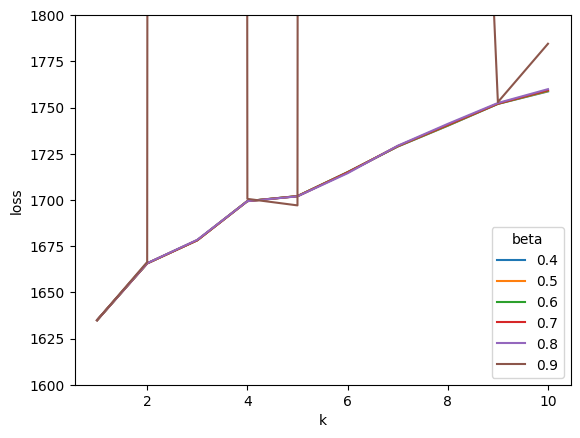

In [39]:
fig, ax = plt.subplots()
sns.lineplot(data=select_cs_results, x="k", y="loss", hue="beta", palette="tab10")
ax.set_ylim([1600,1800])

In [40]:
k_opt, beta_opt, _ = select_cs_results.sort_values(by="loss").iloc[0]

In [41]:
print(f"Optimal latent dim: {k_opt}")
print(f"Optimal beta: {beta_opt}")

Optimal latent dim: 1.0
Optimal beta: 0.7


## Fit 3B-NMD with r=1

In [42]:
k_opt = int(k_opt)

##### Nuclear norm

In [43]:
m, n = data_counts.X.shape
X_nmd = convert_to_dense(data_counts, layer="normalized_counts")
m, n = X_nmd.shape
W0, H0 = cs.nuclear_norm_init(X_nmd, m, n, k_opt)
Theta0 = W0 @ H0

In [44]:
init_strat = InitializationStrategy.KNOWN_MATRIX
kernel_strat = KernelStrategy.MOMENTUM_3_BLOCK_MODEL_FREE

##### Fit NMD

In [45]:
kernel_params = kernelInputTypes.Momentum3BlockAdditionalParameters(
    momentum_beta=beta_opt, 
    candidate_factor_W0=W0, candidate_factor_H0=H0,
)
nmd_result = nmd.decompose(
            X_nmd, k_opt, 
            kernel_strategy=kernel_strat, 
            initialization=init_strat,                  
            kernel_params=kernel_params, 
            manual_max_iterations=200,   
            verbose=True, tolerance=None)

INFO:fi_nomad.entry:	Initiating run, target_rank: 1, tolerance: None
INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 4.466500104172155e-05 loop took 43.096748626998306 overall (0.21548374313499152/ea)


In [46]:
data_counts.obsm["X_NMD_r1"] = nmd_result.factors[0]
data_counts.varm["NMD_components_r1"] = nmd_result.factors[1].T

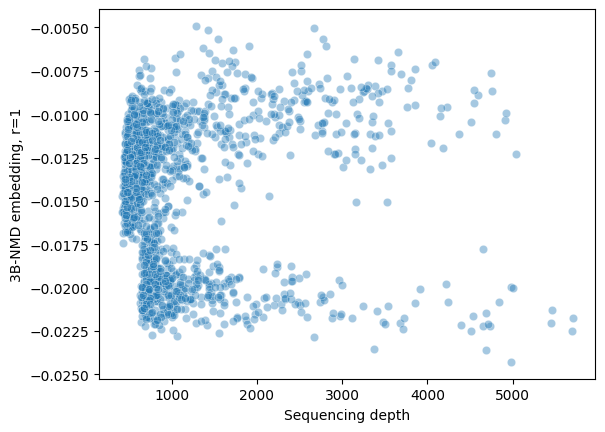

In [47]:
scatter_seqdepth_nmdnormk1 = sns.scatterplot(y=data_counts.obsm["X_NMD_r1"].flatten(), 
                                             x=data_counts.obs["total_counts"], alpha = 0.4)
plt.ylabel("3B-NMD embedding, r=1")
plt.xlabel("Sequencing depth")

plt.show()

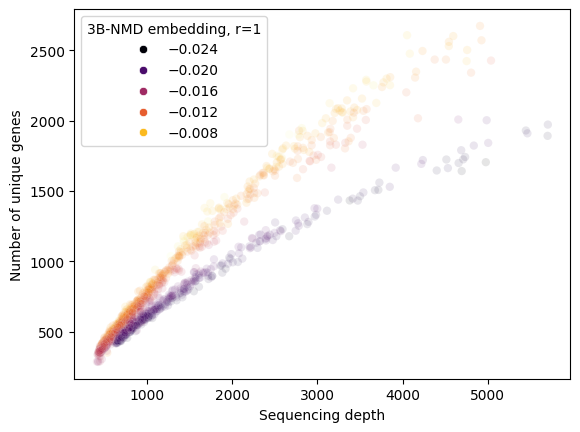

In [48]:
W0_min = W0.flatten().min()

scatter_seqdepth_uniquegenes_hue_nmd_normk1 = sns.scatterplot(x=data_counts.obs["total_counts"], 
                                                              y=data_counts.obs["n_genes_by_counts"], 
                                                            hue=data_counts.obsm["X_NMD_r1"].flatten(), 
                                                              alpha = 0.1, palette="inferno")
plt.ylabel("Number of unique genes")
plt.xlabel("Sequencing depth")
scatter_seqdepth_uniquegenes_hue_nmd_normk1.axes.legend_.set_title("3B-NMD embedding, r=1")

for lh in scatter_seqdepth_uniquegenes_hue_nmd_normk1.axes.legend_.legend_handles:
    lh.set_alpha(1)
plt.show()

## Fit 3B-NMD with r=3

In [49]:
W0_r3, H0_r3 = cs.nuclear_norm_init(X_nmd, m, n, 3)

In [52]:
kernel_params_r3 = kernelInputTypes.Momentum3BlockAdditionalParameters(
    momentum_beta=beta_opt, 
    candidate_factor_W0=W0_r3, candidate_factor_H0=H0_r3,
)
nmd_result_r3 = nmd.decompose(
            X_nmd, 3,
            kernel_strategy=kernel_strat,
            initialization=init_strat,          
            kernel_params=kernel_params_r3,
            manual_max_iterations=200, 
            verbose=True, tolerance=None)

INFO:fi_nomad.entry:	Initiating run, target_rank: 3, tolerance: None
INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 8.334700032719411e-05 loop took 45.74972286800039 overall (0.22874861434000196/ea)


In [54]:
data_counts.obsm["X_nmd_r3"] = nmd_result_r3.factors[0].copy()

In [57]:
importlib.reload(scd)

n_neighborss = [10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 150, 200, 250]
min_dists = [0.05, 0.1, 0.3, 0.5, 0.7]

## scDEED

In [58]:
scdeed_result_r3, rel_scores_r3, null_rel_scores_r3, reliabilities_r3, n_neighbors_opt_r3, min_dist_opt_r3 = scd.scdeed_parameter_selection(
    data_counts, n_neighborss, min_dists, 
    n_pcs=3, 
    rng_seed=674116985, 
    layer = "normalized_counts",
    dim_red_method="3B-NMD", 
    dim_red_params={"beta1": beta_opt}, 
    obsm_embedding_key="X_nmd_r3",
    embedding_method="UMAP", 
    similarity_percent=0.5, 
    save_path=None)

calculating (10, 0.05) - run 1/85


INFO:fi_nomad.entry:	Initiating run, target_rank: 3, tolerance: None
INFO:fi_nomad.entry:300 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.2685000405763276e-05 loop took 57.72556407000047 overall (0.19241854690000157/ea)


calculating (10, 0.1) - run 2/85
calculating (10, 0.3) - run 3/85
calculating (10, 0.5) - run 4/85
calculating (10, 0.7) - run 5/85
calculating (15, 0.05) - run 6/85
calculating (15, 0.1) - run 7/85
calculating (15, 0.3) - run 8/85
calculating (15, 0.5) - run 9/85
calculating (15, 0.7) - run 10/85
calculating (20, 0.05) - run 11/85
calculating (20, 0.1) - run 12/85
calculating (20, 0.3) - run 13/85
calculating (20, 0.5) - run 14/85
calculating (20, 0.7) - run 15/85
calculating (25, 0.05) - run 16/85
calculating (25, 0.1) - run 17/85
calculating (25, 0.3) - run 18/85
calculating (25, 0.5) - run 19/85
calculating (25, 0.7) - run 20/85
calculating (30, 0.05) - run 21/85
calculating (30, 0.1) - run 22/85
calculating (30, 0.3) - run 23/85
calculating (30, 0.5) - run 24/85
calculating (30, 0.7) - run 25/85
calculating (35, 0.05) - run 26/85
calculating (35, 0.1) - run 27/85
calculating (35, 0.3) - run 28/85
calculating (35, 0.5) - run 29/85
calculating (35, 0.7) - run 30/85
calculating (40, 

Optimal number of neighbors: 25
Optimal min_dist: 0.05


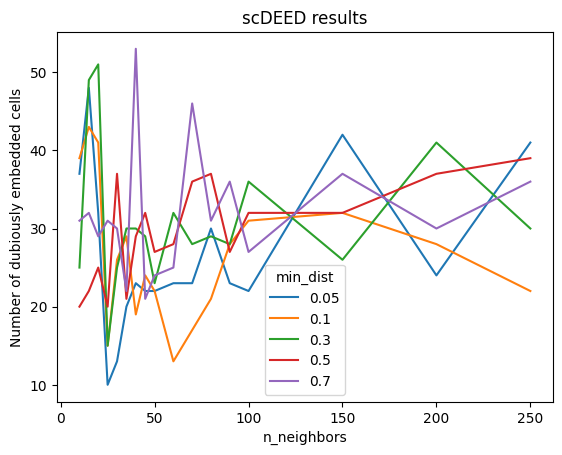

In [59]:
print(f"Optimal number of neighbors: {n_neighbors_opt_r3}")
print(f"Optimal min_dist: {min_dist_opt_r3}")

sns.lineplot(data=scdeed_result_r3, x="n_neighbors", y="num_dubious", hue="min_dist", palette="tab10")
plt.title("scDEED results")
plt.ylabel("Number of dubiously embedded cells")
plt.show()

In [60]:
sc.pp.neighbors(data_counts, n_neighbors=n_neighbors_opt_r3, n_pcs=3, use_rep="X_nmd_r3", key_added="nmd_r3")
sc.tl.umap(data_counts, neighbors_key="nmd_r3", min_dist=min_dist_opt_r3, spread=1)

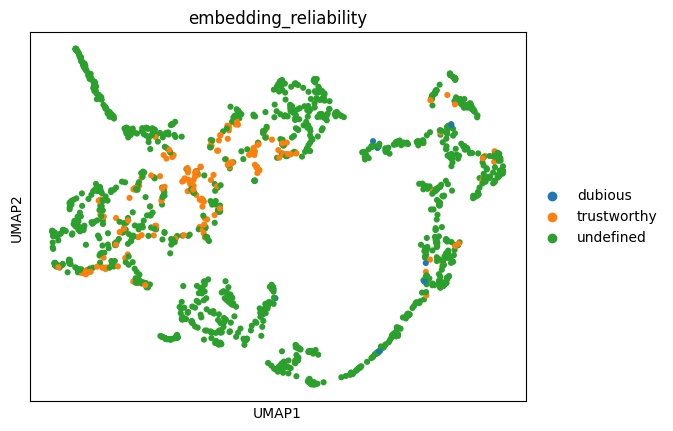

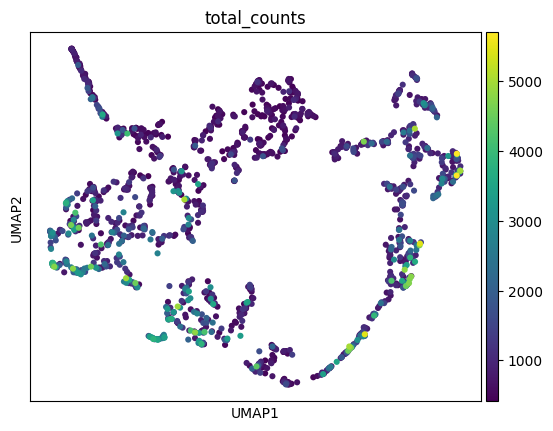

In [62]:
sc.pl.umap(data_counts, color="embedding_reliability", alpha=1, layer="normalized_counts", neighbors_key="nmd_r3")
plt.show()

sc.pl.umap(data_counts, color="total_counts", alpha=1, cmap="viridis", layer="normalized_counts", neighbors_key="nmd_r3")
plt.show()

## Determine optimal resolution

In [73]:
X_train = convert_to_dense(data_train, layer="normalized_counts")
X_test = convert_to_dense(data_test, layer="normalized_counts")

In [74]:
m_train, n_train = X_train.shape
m_test, n_test = X_test.shape

In [75]:
W0_train, H0_train = cs.nuclear_norm_init(X_train, m_train, n_train, 3)
W0_test, H0_test = cs.nuclear_norm_init(X_test, m_test, n_test, 3)

In [76]:
kernel_params_train = kernelInputTypes.Momentum3BlockAdditionalParameters(
    momentum_beta=beta_opt, 
    candidate_factor_W0=W0_train, candidate_factor_H0=H0_train,
)
nmd_result_train = nmd.decompose(
            X_train, 3,
            kernel_strategy=kernel_strat,
            initialization=init_strat,          
            kernel_params=kernel_params_train,
            manual_max_iterations=200, 
            verbose=True, tolerance=None)

INFO:fi_nomad.entry:	Initiating run, target_rank: 3, tolerance: None
INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.150599877699278e-05 loop took 41.2563579939997 overall (0.2062817899699985/ea)


In [77]:
kernel_params_test = kernelInputTypes.Momentum3BlockAdditionalParameters(
    momentum_beta=beta_opt, 
    candidate_factor_W0=W0_test, candidate_factor_H0=H0_test,
)
nmd_result_test = nmd.decompose(
            X_test, 3,
            kernel_strategy=kernel_strat,
            initialization=init_strat,          
            kernel_params=kernel_params_test,
            manual_max_iterations=200, 
            verbose=True, tolerance=None)

INFO:fi_nomad.entry:	Initiating run, target_rank: 3, tolerance: None
INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 4.849899960390758e-05 loop took 41.23729700000149 overall (0.20618648500000744/ea)


In [80]:
data_train.obsm["X_nmd_r3"] = nmd_result_train.factors[0].copy()
data_test.obsm["X_nmd_r3"] = nmd_result_test.factors[0].copy()

In [81]:
sc.pp.neighbors(data_train, n_neighbors=n_neighbors_opt_r3, n_pcs=3, use_rep="X_nmd_r3", key_added="nmd_r3")
sc.pp.neighbors(data_test, n_neighbors=n_neighbors_opt_r3, n_pcs=3, use_rep="X_nmd_r3", key_added="nmd_r3")

In [83]:
importlib.reload(co)
res_min = 0.01
res_max = 0.5
res_step = 0.02
resolutions = np.round(np.arange(res_min, res_max, res_step), 2)

co.cluster_train_test(data_train, data_test, resolutions, alg="leiden", neighbors_key="nmd_r3")

In [84]:
importlib.reload(co)
mod_df, mod_df_wide, res_opt = co.find_optimal_clustering_resolution(data_train, data_test, resolutions, neighbors_key="nmd_r3")

print(f"Optimal resolution {res_opt}")

resolution: 0.01 - clusters: 1 - Train: 0.49 - Test: 0.49 - Random: 0.49
resolution: 0.03 - clusters: 2 - Train: 0.47 - Test: 0.334 - Random: 0.242
resolution: 0.05 - clusters: 2 - Train: 0.46 - Test: 0.32 - Random: 0.228
resolution: 0.07 - clusters: 3 - Train: 0.454 - Test: 0.243 - Random: 0.151
resolution: 0.09 - clusters: 4 - Train: 0.446 - Test: 0.192 - Random: 0.103
resolution: 0.11 - clusters: 5 - Train: 0.442 - Test: 0.174 - Random: 0.087
resolution: 0.13 - clusters: 5 - Train: 0.438 - Test: 0.168 - Random: 0.08
resolution: 0.15 - clusters: 5 - Train: 0.434 - Test: 0.153 - Random: 0.07
resolution: 0.17 - clusters: 6 - Train: 0.429 - Test: 0.131 - Random: 0.057
resolution: 0.19 - clusters: 7 - Train: 0.423 - Test: 0.118 - Random: 0.044
resolution: 0.21 - clusters: 7 - Train: 0.42 - Test: 0.112 - Random: 0.043
resolution: 0.23 - clusters: 8 - Train: 0.418 - Test: 0.106 - Random: 0.036
resolution: 0.25 - clusters: 8 - Train: 0.415 - Test: 0.103 - Random: 0.033
resolution: 0.27 - cl

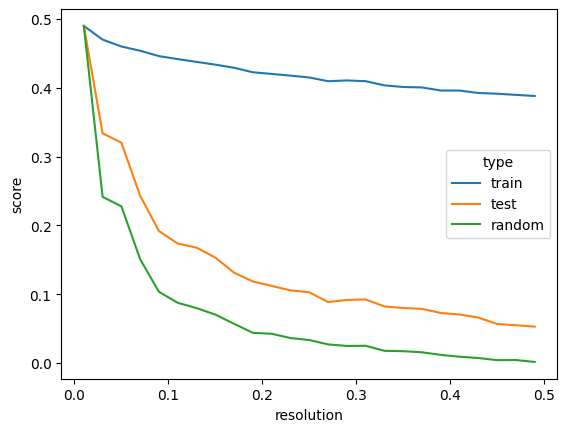

In [85]:
sns.lineplot(data=mod_df, x="resolution", y="score", hue="type")
plt.show()

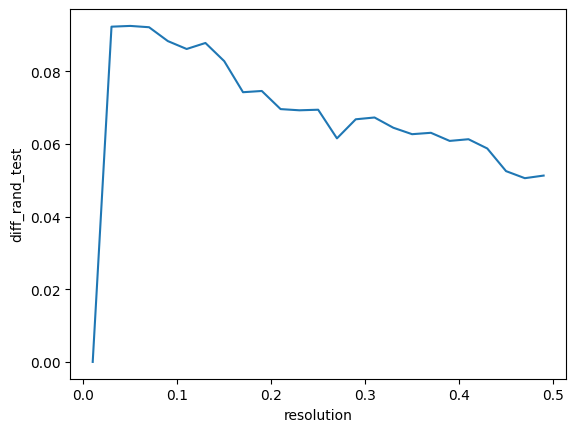

In [86]:
sns.lineplot(data=mod_df_wide, x="resolution", y="diff_rand_test")
plt.show()

In [87]:
sc.tl.leiden(data_counts, resolution=res_opt, key_added="leiden_opt", neighbors_key="nmd_r3")

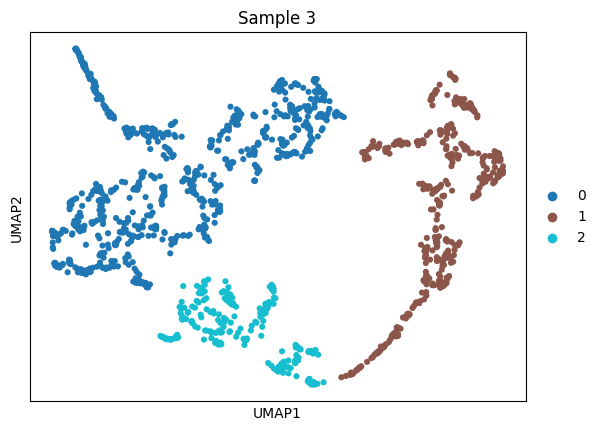

In [88]:
sc.pl.umap(data_counts, color="leiden_opt", palette="tab10", title="Sample 3", neighbors_key="nmd_r3")
plt.show()

In [89]:
data_counts.obsm_keys()

['X_pca', 'X_NMD_r1', 'X_nmd_r3', 'X_umap']

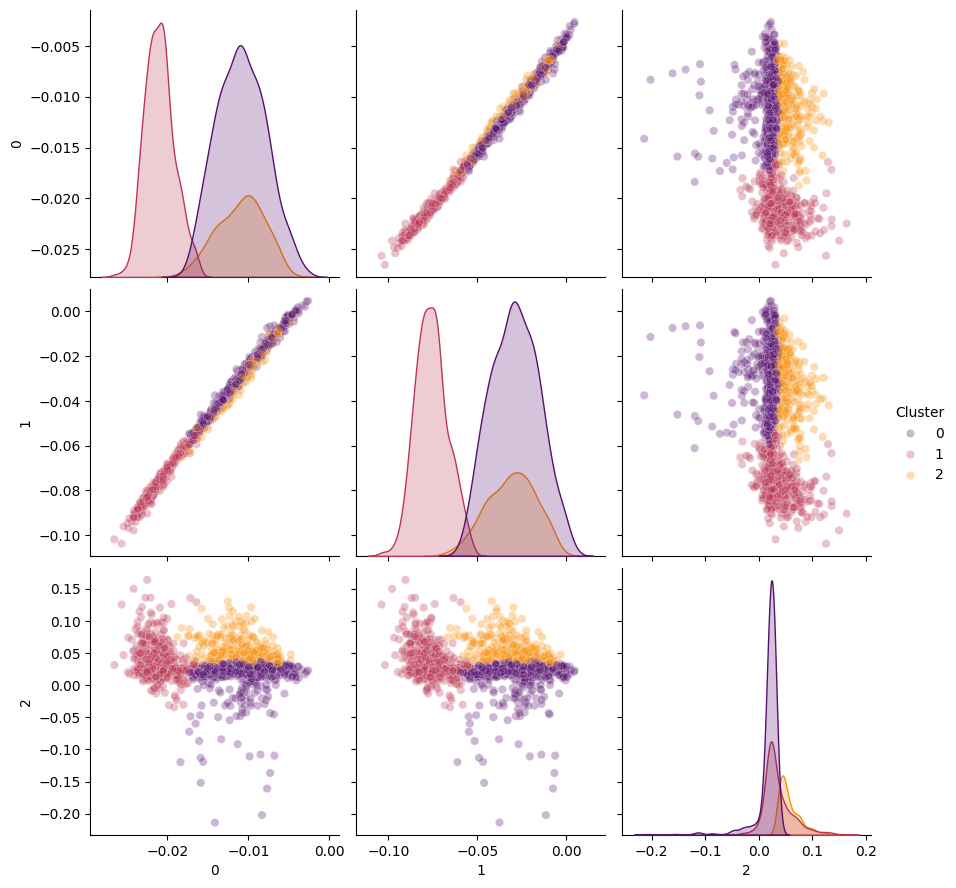

In [90]:
nmd_plot.plot_embedding_grid(data_counts.obsm["X_nmd_r3"], hue=data_counts.obs["leiden_opt"], size=3)

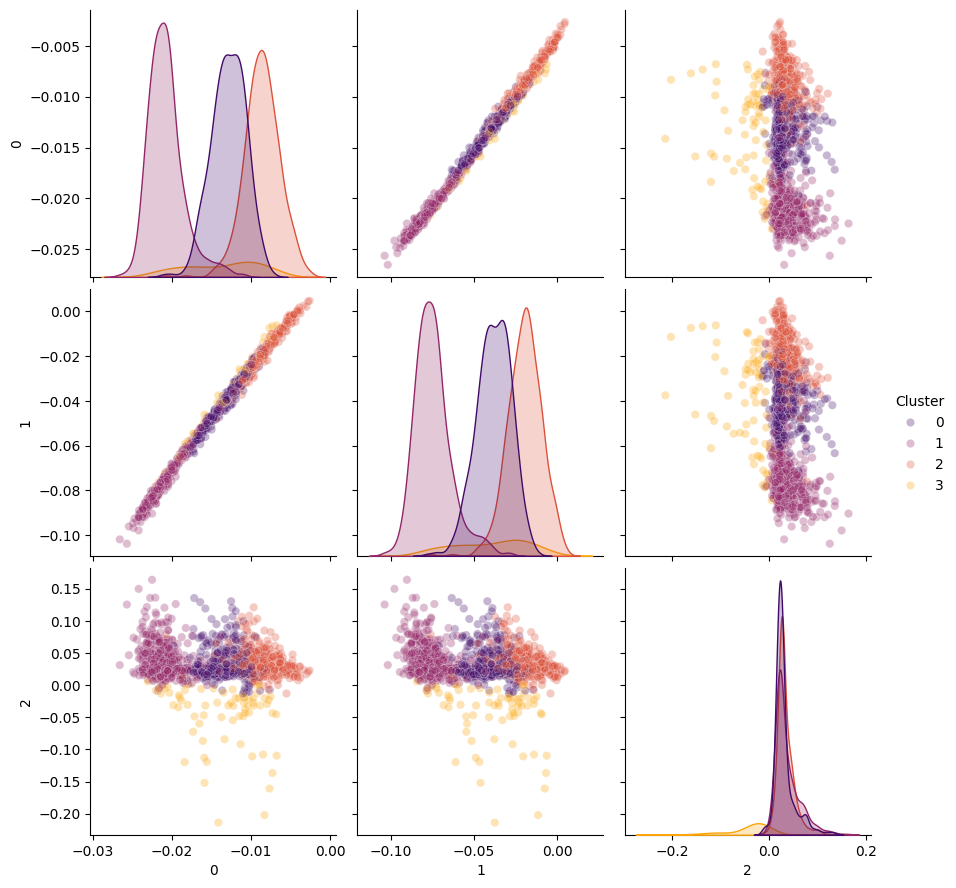

In [92]:
nmd_plot.plot_embedding_grid(data_counts.obsm["X_nmd_r3"], hue=data_all_pca.obs["leiden_opt"], size=3)

In [91]:
pd.crosstab(data_all_pca.obs["leiden_opt"], data_counts.obs["leiden_opt"], rownames=['PCA'], colnames=['NMD'])

NMD    0    1    2
PCA               
0    394   21  102
1     25  448    9
2    319    2  150
3     55   19    0

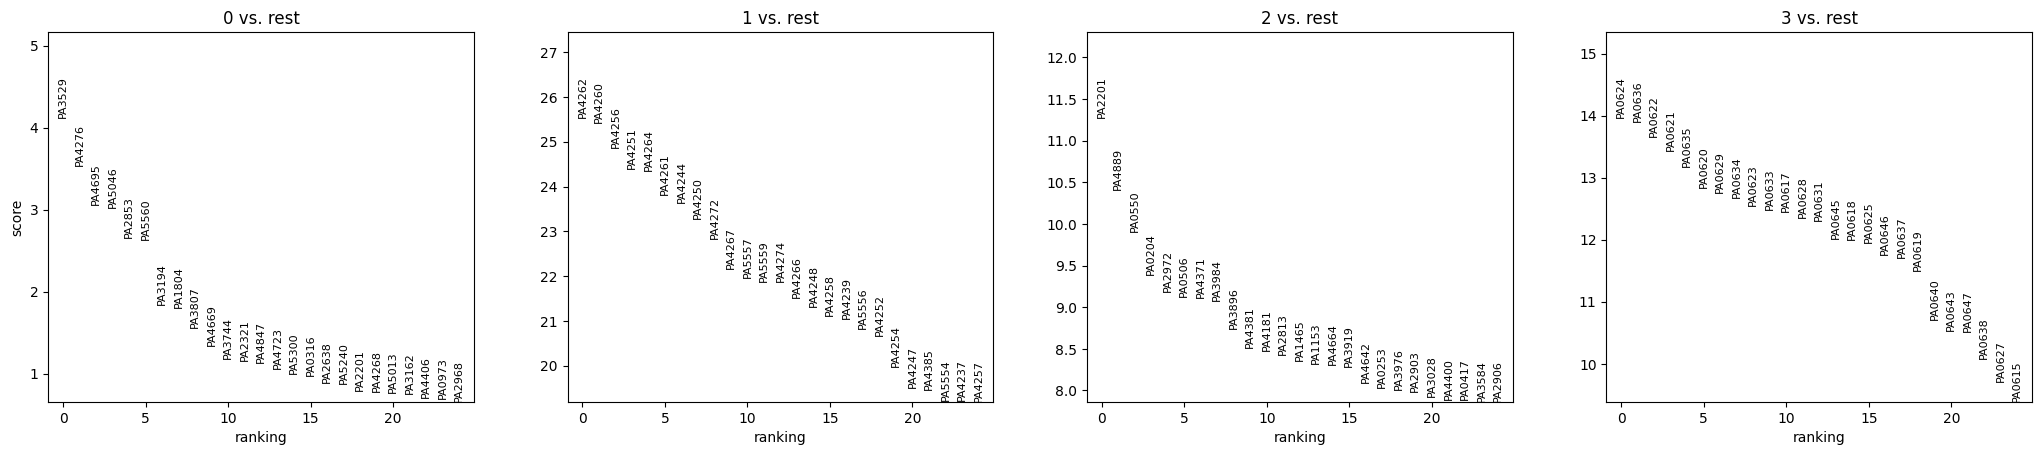

In [93]:
sc.tl.rank_genes_groups(data_all_pca, 'leiden_opt', method='wilcoxon')
sc.pl.rank_genes_groups(data_all_pca, n_genes=25, sharey=False)

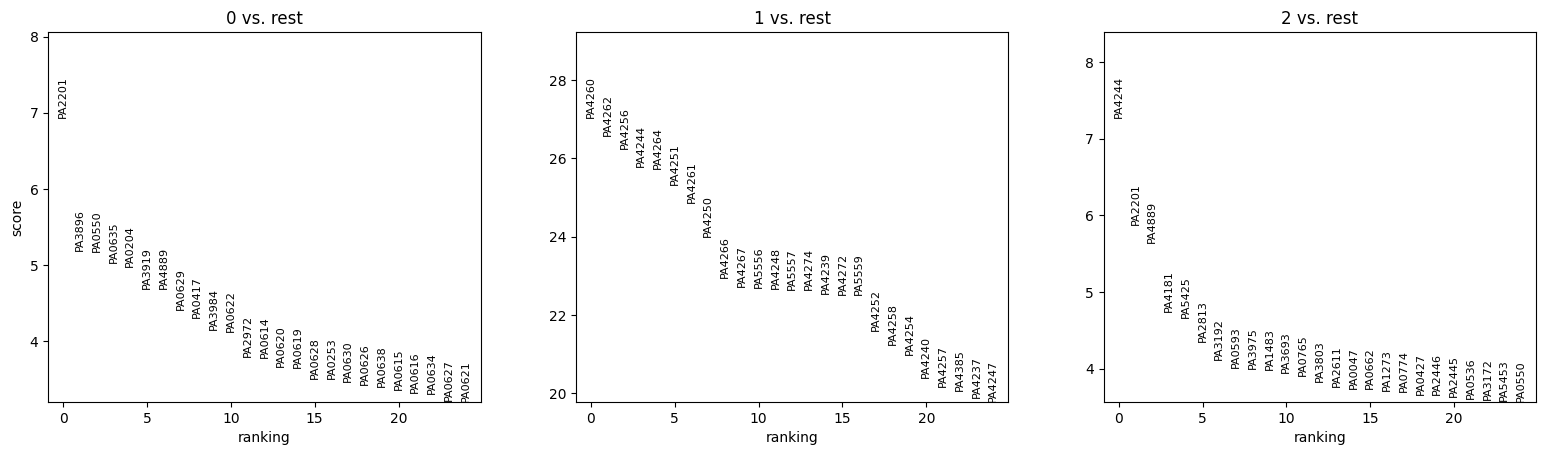

In [94]:
sc.tl.rank_genes_groups(data_counts, 'leiden_opt', method='wilcoxon')
sc.pl.rank_genes_groups(data_counts, n_genes=25, sharey=False)

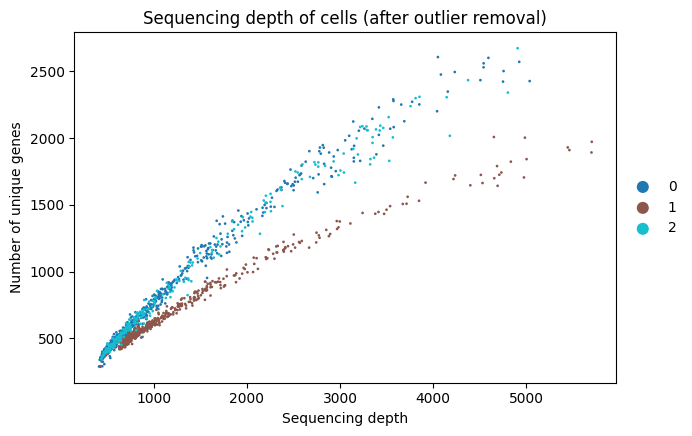

In [95]:
sc.pl.scatter(data_counts, x='total_counts', y='n_genes_by_counts', show=False, size=15, color="leiden_opt")
plt.title("Sequencing depth of cells (after outlier removal)")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
plt.show()

In [97]:
top_genes_3 = [x[2] for x in data_counts.uns["rank_genes_groups"]["names"]]
print(top_genes_3[:25])

['PA4244', 'PA2201', 'PA4889', 'PA4181', 'PA5425', 'PA2813', 'PA3192', 'PA0593', 'PA3975', 'PA1483', 'PA3693', 'PA0765', 'PA3803', 'PA2611', 'PA0047', 'PA0662', 'PA1273', 'PA0774', 'PA0427', 'PA2446', 'PA2445', 'PA0536', 'PA3172', 'PA5453', 'PA0550']


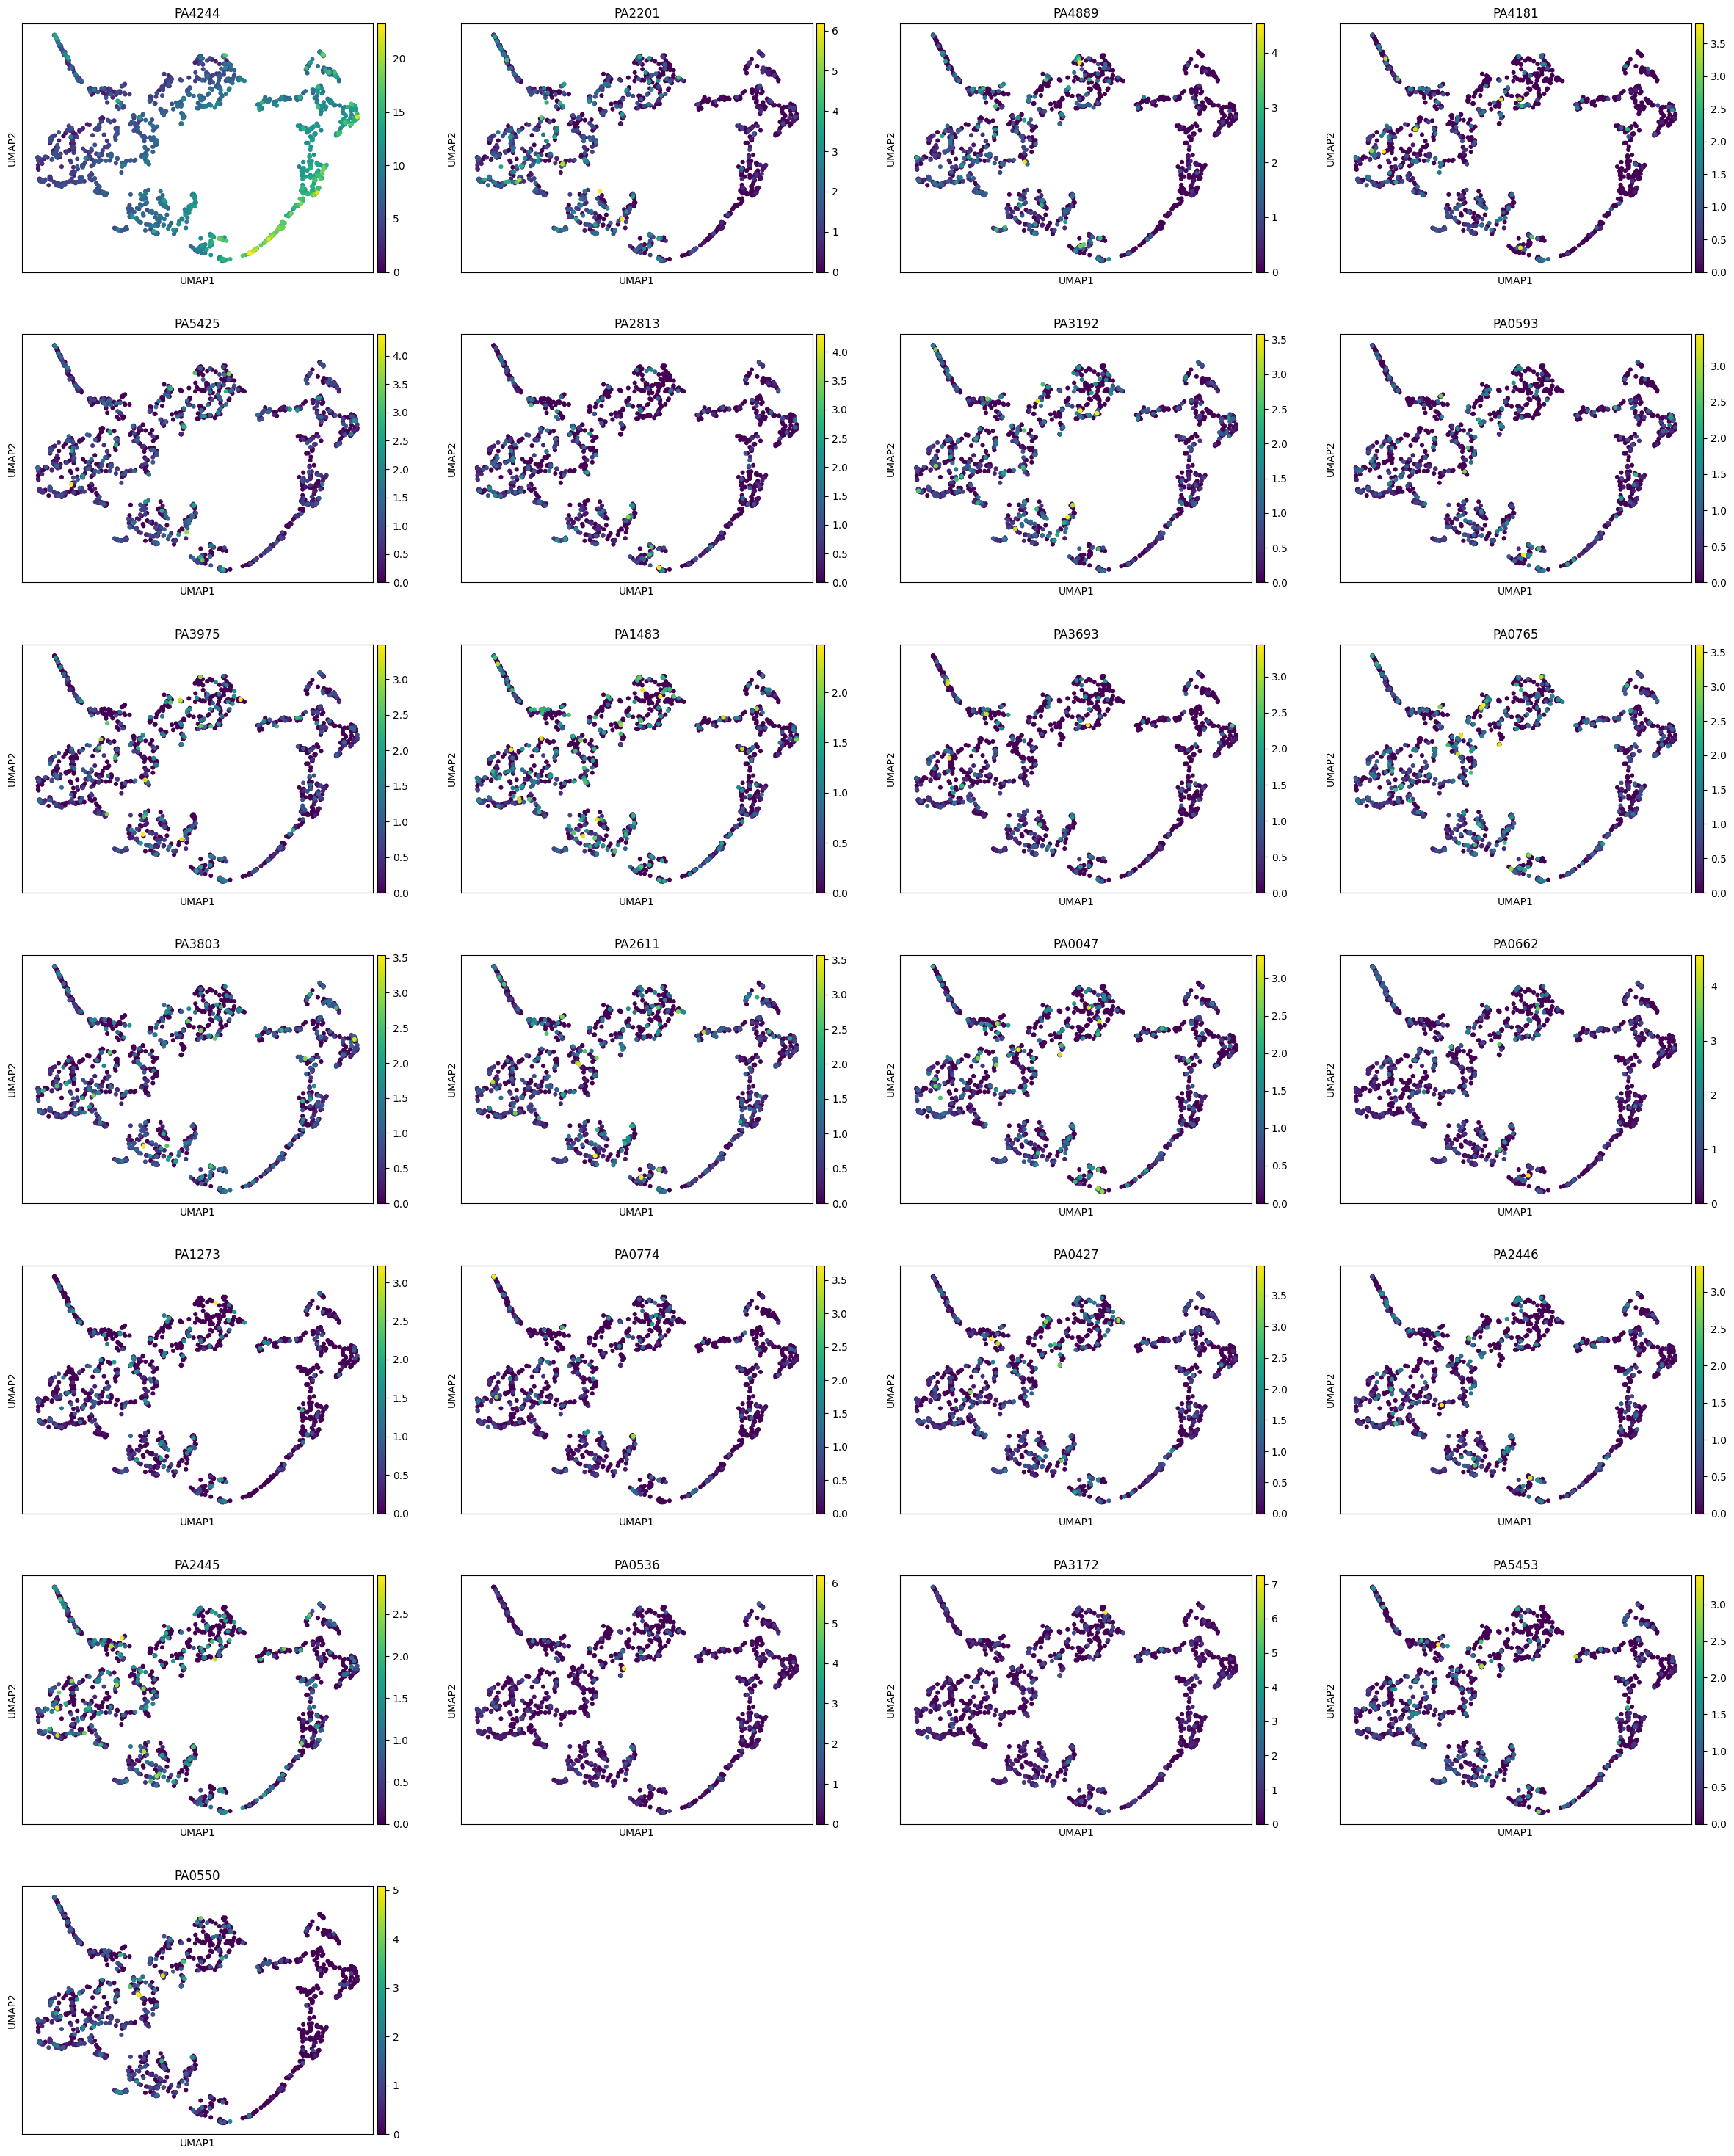

In [98]:
sc.pl.umap(data_counts, color=top_genes_3[:25], palette="tab20", cmap="viridis")

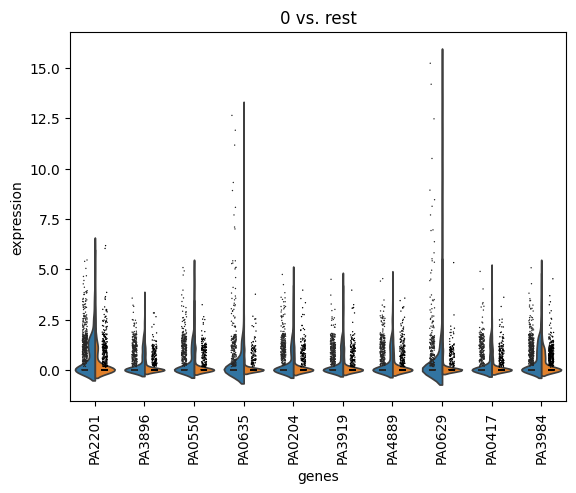

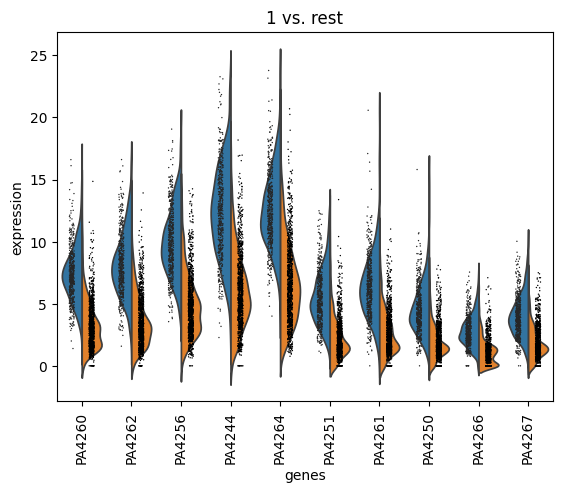

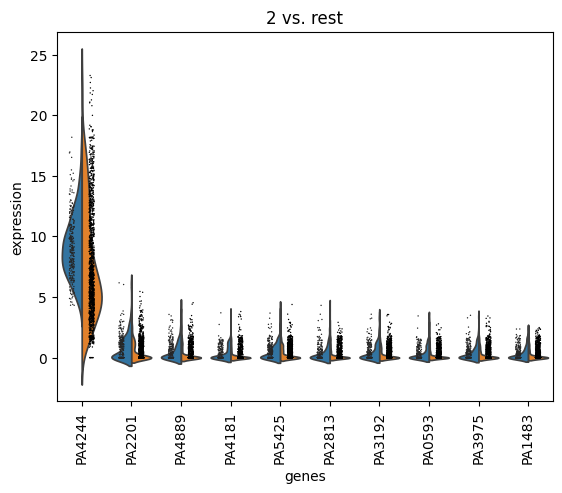

In [96]:
nclust = len(np.unique(data_counts.obs["leiden_opt"]))

for i in range(nclust):
    sc.pl.rank_genes_groups_violin(data_counts, groups=str(i), n_genes=10)